In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import re
import gc
import allel

## Functions

In [4]:
def hudson_fst(ac1, ac2):

    n1 = ac1.shape[1]
    n2 = ac2.shape[1]

    af1 = np.sum(ac1, axis=1)/n1/2
    af2 = np.sum(ac2, axis=1)/n2/2

    num = (af1 - af2)**2  - (af1 * (1 - af1))/(n1 - 1) - (af2 * (1 - af2))/(n2 - 1)
    den = af1 * (1 - af2) + af2 * (1 - af1)

    fst = np.where(den > 0, num/den, 0)

    return(fst)

In [5]:
def pbs_norm(ac1, ac2, ac3):

    fst12 = hudson_fst(ac1, ac2)
    fst13 = hudson_fst(ac1, ac3)
    fst23 = hudson_fst(ac2, ac3)

    t12 = -np.log(1 - fst12)
    t13 = -np.log(1 - fst13)
    t23 = -np.log(1 - fst23)

    pbs1 = (t12 + t13 - t23)/2
    pbs2 = (t12 + t23 - t13)/2
    pbs3 = (t13 + t23 - t12)/2

    den = (1 + pbs1 + pbs2 + pbs3)
    
    return(pbs1/den, pbs2/den, pbs3/den)

## Main

In [12]:
pops_info = pd.read_csv("../../misc/id_pop.txt", sep="\t", names=['TID','Ethnicity'], skiprows=1)

In [13]:
samps = allel.read_vcf_headers("../eqtl/data/genotype/africa6k_public.topmed10.GOLD.chr22.maf05.biallelic.sc.cameroon.vcf.gz")[-1]

In [14]:
pop_df = pd.DataFrame({'TID':samps}).merge(pops_info)

In [15]:
# read in genotype data
vcfs = []
snps = []

for i in range(1,23):
    
    vcf_f = "../eqtl/data/genotype/africa6k_public.topmed10.GOLD.chr{}.maf05.biallelic.sc.cameroon.vcf.gz".format(i)
    vcf = allel.read_vcf(vcf_f)
    snp = vcf['variants/ID']
    gt_array = allel.GenotypeArray(vcf['calldata/GT']).to_n_alt()

    vcfs.append(gt_array)
    snps.append(snp)

In [16]:
vcf = np.concatenate(vcfs)

In [17]:
snp_ids = [i for s in snps for i in s]

In [24]:
t_ac = vcf[:,pop_df['Ethnicity']=="Tikari"]
f_ac = vcf[:,pop_df['Ethnicity']=="Fulani"]
c_ac = vcf[:,(pop_df['Ethnicity']=="Baka") | (pop_df['Ethnicity']=="Baka")]

In [25]:
t_af = np.mean(t_ac, axis=1)/2
f_af = np.mean(f_ac, axis=1)/2
c_af = np.mean(c_ac, axis=1)/2

In [35]:
t_pbs, f_pbs, c_pbs = pbs_norm(t_ac, f_ac, c_ac)

/tmp/ipykernel_161391/3574228300.py:12: RuntimeWarning: invalid value encountered in divide
  fst = np.where(den > 0, num/den, 0)


/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: >

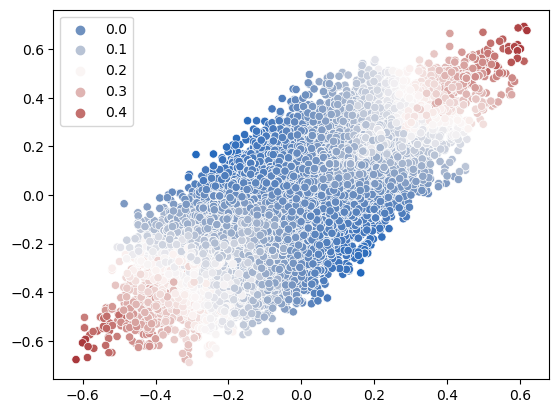

In [26]:
sns.scatterplot(x=f_af - t_af, y=f_af - c_af, hue=f_pbs, palette='vlag')

In [49]:
pbs_all = pd.DataFrame({'variant_id': snp_ids, 'Tikari_PBS': t_pbs, 'Fulani_PBS': f_pbs, 'CHG_PBS': c_pbs})

In [50]:
pbs_all.to_csv("output/A6K.sc.cameroon.maf05.biallelic.pbs.tsv.gz", sep="\t", index=False)

In [6]:
pbs_all = pd.read_csv("output/A6K.sc.cameroon.maf05.biallelic.pbs.tsv.gz", sep="\t")

In [44]:
eqtl_perm = pd.read_csv("../eqtl/output/eqtl_all/tensorqtl_permute.CD4-T.LPS.17pcs.csv")

In [45]:
eqtl_sig = eqtl_perm[eqtl_perm['qval'] < 0.05]

In [46]:
eqtl_sig.shape

(3910, 19)

In [47]:
f_af[np.array(snp_ids)=="chr19_38815785_A_C	"]

array([], dtype=float64)

In [ ]:
t_af[np.array(snp_ids)=="chr19_38815785_A_C	"]

In [ ]:
c_af[np.array(snp_ids)=="chr19_38815785_A_C	"]

In [48]:
eqtl_sig_pbs = eqtl_sig.merge(pbs_all)

In [50]:
#eqtl_sig_afs.loc[np.argsort(-np.abs(eqtl_sig_afs['Tikari_af'] - eqtl_sig_afs['Fulani_af'])),:].head(20)
eqtl_sig_pbs.sort_values('Tikari_PBS', ascending=False).head(20)

,phenotype_id,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,start_distance,end_distance,ma_samples,...,pval_nominal,slope,slope_se,pval_perm,pval_beta,qval,pval_nominal_threshold,Tikari_PBS,Fulani_PBS,CHG_PBS
0,NOC2L,740,1.082034,95.895620,83.486305,2.734420e-04,chr1_957080_G_C,-2229,-2229,59,...,3.745288e-05,-0.245036,0.056950,0.015698,1.850578e-02,1.068767e-02,0.001832,0.239779,0.074112,-0.064661
3610,RABAC1,259,1.024614,24.915487,88.943330,5.335086e-13,chr19_41925681_G_A,-33640,-33640,85,...,2.399193e-15,0.401830,0.043389,0.000100,7.104159e-12,3.292721e-11,0.006139,0.208988,-0.012968,-0.005307
3020,NME3,933,1.043801,41.326470,83.251305,4.953677e-04,chr16_1769432_G_A,-2298,-2298,96,...,7.764882e-05,-0.250039,0.060831,0.013399,1.677603e-02,9.868255e-03,0.003883,0.202334,0.027230,-0.040751
3021,MRPS34,935,1.041589,40.909630,83.554990,4.677272e-06,chr16_1769432_G_A,-3723,-3723,96,...,2.162359e-07,-0.287476,0.051868,0.000100,1.316724e-04,1.535477e-04,0.003901,0.202334,0.027230,-0.040751
309,BLZF1,530,1.042499,19.908140,85.404700,5.456962e-04,chr1_169373418_T_G,5448,5448,104,...,1.079407e-04,-0.262853,0.065360,0.006099,8.762988e-03,5.758155e-03,0.008014,0.200852,-0.065781,0.076477
978,TMEM156,784,1.060136,82.456280,87.996130,1.476371e-06,chr4_39035185_G_A,2263,2263,75,...,1.087263e-07,0.528141,0.092715,0.000100,6.896181e-05,8.598141e-05,0.002025,0.196503,-0.049938,0.047310
2454,AC010168.1,636,1.039954,31.407070,84.058600,1.217373e-14,chr12_14759928_TA_T,94273,94273,68,...,3.074262e-18,-0.721054,0.068422,0.000100,1.199646e-13,7.328383e-13,0.005058,0.182933,-0.000913,-0.018075
3807,AGPAT3,639,1.043397,60.638195,83.764530,2.194250e-03,chr21_43863076_A_G,-2147,-2147,112,...,5.329543e-04,0.199537,0.055866,0.106589,1.119994e-01,4.335078e-02,0.002646,0.178517,-0.082402,0.128203
2774,KLHDC1,428,1.033802,23.914387,83.958380,7.854599e-07,chr14_49665010_T_C,-28095,-28095,92,...,2.417376e-08,0.315578,0.052366,0.000100,1.282248e-05,1.851713e-05,0.006539,0.175618,0.025724,-0.039698
1593,ELMO1-AS1,491,1.051006,68.389145,87.828950,7.558187e-05,chr7_37004547_C_T,6751,6751,53,...,1.237615e-05,-0.287784,0.062767,0.003300,3.855533e-03,2.886707e-03,0.002389,0.172681,0.021865,-0.035962


In [26]:
f_af[np.where(np.array(snp_ids)=="chr12_121491033_A_G")]

array([0.23333333])

In [27]:
c_af[np.where(np.array(snp_ids)=="chr12_121491033_A_G")]

array([0.85714286])

In [28]:
t_af[np.where(np.array(snp_ids)=="chr12_121491033_A_G")]

array([0.85245902])

In [33]:
np.quantile(pbs_all['Fulani_PBS'], 0.99)

0.22999661096477114

In [42]:
idx = np.argsort(pbs_all['Fulani_PBS'])[-10000:]

/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: >

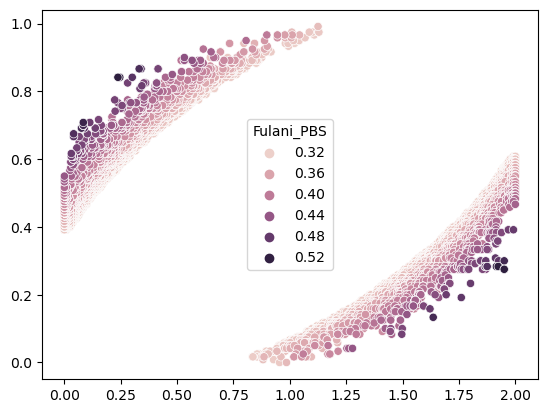

In [43]:
sns.scatterplot(x=t_af[idx] + c_af[idx], 
                y=f_af[idx], 
                hue=pbs_all['Fulani_PBS'][idx])

## LAG3 SNP

In [26]:
vcf_f = "../eqtl/data/genotype/africa6k_public.topmed10.GOLD.chr16.maf05.biallelic.sc.cameroon.vcf.gz"
vcf = allel.read_vcf(vcf_f)
snp = vcf['variants/ID']
gt_array = allel.GenotypeArray(vcf['calldata/GT']).to_n_alt()

In [27]:
t_af = np.mean(gt_array[:,pop_df['Ethnicity']=="Tikari"], axis=1)/2
f_af = np.mean(gt_array[:,pop_df['Ethnicity']=="Fulani"], axis=1)/2
c_af = np.mean(gt_array[:,(pop_df['Ethnicity']=="Baka") | (pop_df['Ethnicity']=="Baka")], axis=1)/2

In [51]:
f_af[f_af[np.where(np.array(snp_ids)=="chr2_191011343_G_A")]

array([0.28333333, 0.20833333, 0.2       , ..., 0.50833333, 0.06666667,
       0.16666667])

In [30]:
# LAG3 SNP
t_af[vcf['variants/ID']=="chr16_2219234_G_C"]

array([0.09836066])

In [31]:
f_af[vcf['variants/ID']=="chr16_2219234_G_C"]

array([0.025])

In [32]:
c_af[vcf['variants/ID']=="chr16_2219234_G_C"]

array([0.08571429])

## Explore

In [19]:
cols = ['chr','start','end','score','snp_pos','ref/alt','Tikari','Fulani','CHG']
bed_pbs = pd.read_csv("peaks_pbs.sort.bed.gz", sep="\t", names=cols).drop_duplicates()

In [22]:
bed_pbs.sort_values('Fulani', ascending=False).head(20)

,chr,start,end,score,snp_pos,ref/alt,Tikari,Fulani,CHG
105250,chr14,63507991,63508491,9.110148,63508248,A|G,-0.047873,0.485697,0.046493
302474,chr6,14704137,14704637,1.306660,14704366,C|T,0.000493,0.470783,-0.012816
75843,chr12,22380045,22380545,181.072759,22380386,C|A,-0.057262,0.466092,0.083312
75882,chr12,22618537,22619037,18.993710,22619008,C|G,-0.028600,0.454922,0.019182
88252,chr12,121490832,121491332,50.068514,121491033,A|G,-0.008965,0.454371,-0.003655
105244,chr14,63494553,63495053,7.987139,63494839,A|G,-0.008965,0.454371,-0.003655
234501,chr22,46374273,46374773,205.014735,46374277,G|A,-0.067867,0.451049,0.070306
231024,chr22,36276567,36277067,4.959032,36276904,CTGTT|C,0.032676,0.450372,-0.032676
231027,chr22,36279202,36279702,3.127909,36279318,A|G,0.032676,0.450372,-0.032676
198551,chr2,152363906,152364406,16.659446,152364105,C|A,0.054155,0.447976,-0.054312


In [79]:
snp_ids[int(np.where(np.abs(t_af - f_af)==np.max(np.abs(t_af - f_af)))[0])]

'chr14_63544119_A_G'

In [67]:
t_af[np.where(np.abs(t_af - f_af)==np.max(np.abs(t_af - f_af)))]

array([0.96721311])

In [20]:
t_af[np.array(snp_ids)=="chr6_13163469_G_C"]

array([0.14754098])

In [21]:
c_af[np.array(snp_ids)=="chr6_13163469_G_C"]

array([0.02857143])

In [22]:
f_af[np.array(snp_ids)=="chr6_13163469_G_C"]

array([0.00833333])

Write out top 500 peaks for GREAT, as well as background

In [13]:
bed_pbs.sort_values('Fulani', ascending=False).head(500)[['chr','start','end']].drop_duplicates().to_csv("peaks_pbs.top500_Fulani.bed", sep="\t", index=False, header=False)

In [14]:
bed_pbs[['chr','start','end']].drop_duplicates().to_csv("peaks_pbs.bg.bed", sep="\t", index=False, header=False)